<a href="https://colab.research.google.com/github/fbertran/m2csmi/blob/master/Digue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install openturns

In [0]:
import openturns as ot
import random
import math
from math import sqrt

#When the river height exceeds that of the dyke, flooding occurs.

####################
# Flooding function
####################

def flooding_python(x) :
#  Q, Ks, Zv, Zm, Hd, Cb, L, B = x
  Q=x[0]
  if Q<500.:
    Q=500.
  elif Q>3000.:
    Q=3000.
  Ks=x[1]
  if Ks<15.:
    Ks=15.
  Zv=x[2]
  Zm=x[3]
  Hd=x[4]
  Cb=x[5]
  L=x[6]
  B=x[7]
  H = (Q/(B*Ks*sqrt((Zm-Zv)/L)))**0.6
  S = Zv + H - Hd - Cb
  return [S]

# Use that function defined in the script python
# with the openturns library
flooding = ot.PythonFunction(8,1,flooding_python)


In [0]:
####################
# Cost function
####################

def cost_python(x) :
#  Q, Ks, Zv, Zm, Hd, Cb, L, B = x
  Q=x[0]
  Ks=x[1]
  Zv=x[2]
  Zm=x[3]
  Hd=x[4]
  Cb=x[5]
  L=x[6]
  B=x[7]
  S = flooding(x)[0];
  Cp = 0.
  if S>0.:
    Cp += 1.
  else:
    Cp += 0.2 + 0.8*(1-math.exp(-1000/S**4))
  if Hd>8.:
    Cp += Hd/20.
  else:
    Cp += 8./20.
  return [Cp]

cost = ot.PythonFunction(8,1,cost_python)


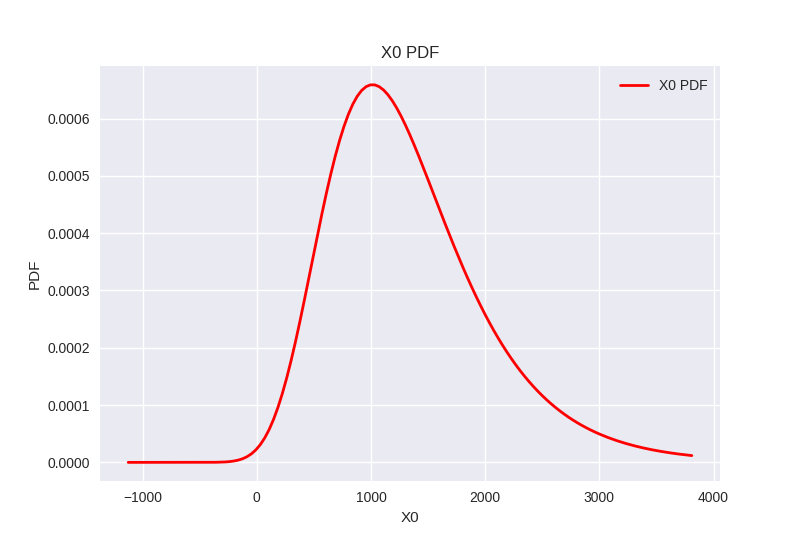

In [0]:
#######################
### Input random vector
#######################

distributionQ = ot.Gumbel(1/558.,1013.)
#distributionQ.setParameter(ot.GumbelMuSigma()([1013.,558.]))
distributionKs = ot.Normal(30.,8.)
distributionZv = ot.Triangular(49.,50.,51.)
distributionZm = ot.Triangular(54.,55.,56.)
distributionHd = ot.Uniform(1.,2.)
distributionCb = ot.Triangular(55.,55.5,56.)
distributionL = ot.Triangular(4990.,5000.,5010.)
distributionB = ot.Triangular(295.,300.,305.)
distributionQ.drawPDF()

In [0]:
collectionMarginals = [distributionQ,distributionKs,distributionZv,distributionZm,distributionHd,distributionCb,distributionL,distributionB]
aCopula = ot.IndependentCopula(len(collectionMarginals))
aCopula.setName("Independent copula")

inputDistribution = ot.ComposedDistribution(collectionMarginals, ot.Copula(aCopula))
inputDistribution.setDescription(("Q","Ks","Zv","Zm","Hd","Cb","L","B"))

inputRandomVector = ot.RandomVector(inputDistribution)
inputRandomVector.setDescription(("Q","Ks","Zv","Zm","Hd","Cb","L","B"))

outputS = ot.RandomVector(flooding, inputRandomVector)
outputCp = ot.RandomVector(cost, inputRandomVector)

In [0]:
###############################
# a) Probabilite de flooding
##############################

ot.RandomGenerator.SetSeed(random.randint(1,100))

myEvent = ot.Event(outputS, ot.Greater(), 0.0)
myEvent.setName("Flooding!")

print("################")
print("Monte Carlo")
print("################")
print("")

maximumOuterSampling = 100000
blockSize = 1
coefficientOfVariation = 0.1

# Creation de l'algorithme Monte Carlo
experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent,experiment)
algoMC.setMaximumOuterSampling(maximumOuterSampling)
algoMC.setBlockSize(blockSize)
algoMC.setMaximumCoefficientOfVariation(coefficientOfVariation)

algoMC.setConvergenceStrategy(ot.Full())
# For statistics about the algorithm
initialNumberOfCall = flooding.getEvaluationCallsNumber()


algoMC.run()

result = algoMC.getResult()
print("MC estimate of the probability of flooding : ", result.getProbabilityEstimate())
print("Variance of the MC estimator : ", result.getVarianceEstimate())
print('CV =', result.getCoefficientOfVariation())
#print('MonteCarlo result=', result)
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the flooding function =', flooding.getEvaluationCallsNumber() - initialNumberOfCall)


################
Monte Carlo
################

MC estimate of the probability of flooding :  0.00032
Variance of the MC estimator :  3.198975999999987e-09
CV = 0.17674840876228523
Number of executed iterations = 100000
Number of calls to the flooding function = 100000


For the flooding:
First Order Sobol Indices:  [0.519865,0.170145,0.213321,0.0151476,0.0894292,0.056529,0.0133864,0.0137853]
Total Order Sobol Indices:  [0.499295,0.180577,0.195133,0.00373925,0.0808207,0.0377574,5.61163e-06,-0.000346565]


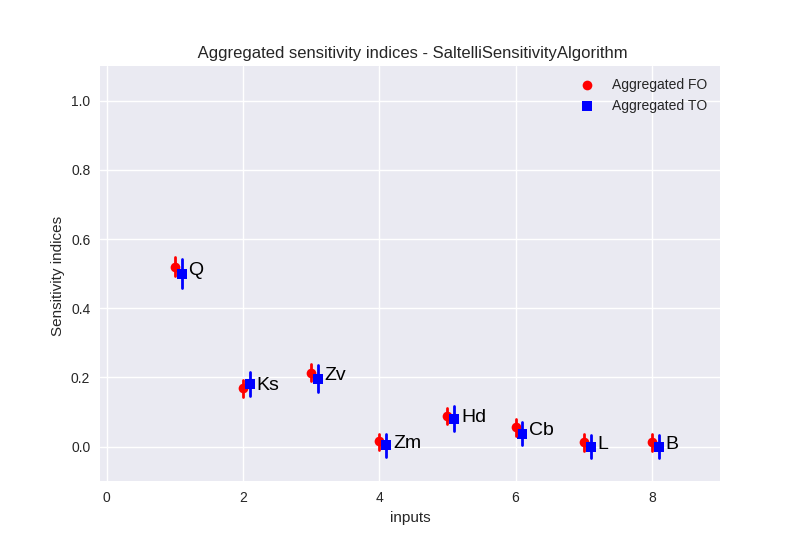

In [0]:
################################
# b) Sobol Indices
################################

size = 10000

###For the Flooding
inputDesignS = ot.SobolIndicesExperiment(inputDistribution, size, True).generate()
outputDesignS = flooding(inputDesignS)
sensitivityAnalysisS = ot.SaltelliSensitivityAlgorithm(inputDesignS, outputDesignS, size)

#First order Sobol indices
print("For the flooding:")
print("First Order Sobol Indices: ", sensitivityAnalysisS.getFirstOrderIndices())
#Total order Sobol indices
print("Total Order Sobol Indices: ", sensitivityAnalysisS.getTotalOrderIndices())

#Graph file
sensitivityAnalysisS.draw()

For the cost:
First Order Sobol Indices: [0.426142,0.113365,0.222843,0.00514129,0.086508,0.0414941,0.00283418,0.00288559]
Total Order Sobol Indices:  [0.524399,0.156209,0.276192,0.00296831,0.117492,0.0561799,2.48213e-06,0.000145876]


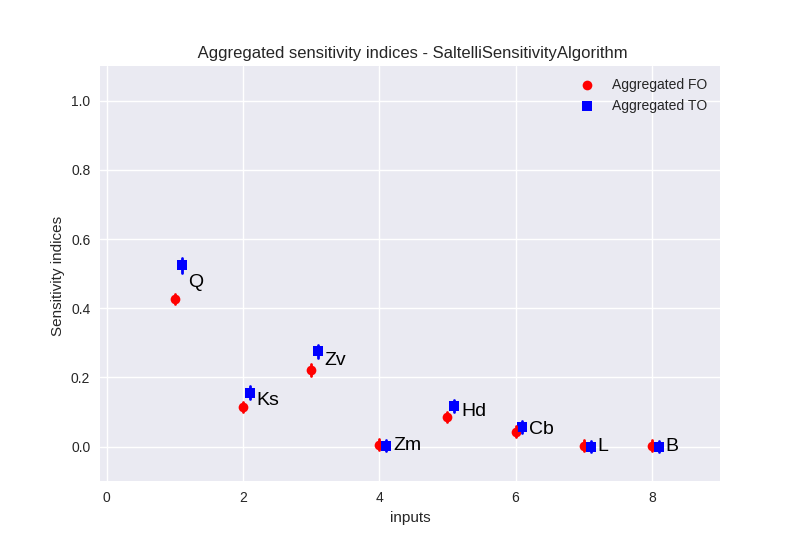

In [0]:
###For the cost
size = 30000

inputDesignCp = ot.SobolIndicesExperiment(inputDistribution, size, True).generate()
outputDesignCp = cost(inputDesignCp)
sensitivityAnalysisCp = ot.SaltelliSensitivityAlgorithm(inputDesignCp, outputDesignCp, size)

#First order Sobol indices
print("For the cost:")
print("First Order Sobol Indices:", sensitivityAnalysisCp.getFirstOrderIndices())
#Total order Sobol indices
print("Total Order Sobol Indices: ", sensitivityAnalysisCp.getTotalOrderIndices())

#Graph file
sensitivityAnalysisCp.draw()

In [0]:
##########################
# c) Metamodel
##########################

#A LatinHyperSquare should be used instead of random points.
X = inputRandomVector.getSample(100)
dim = X.getDimension()

Y1 = flooding(X)
Y2 = cost(X)

#Just one of the possible covariance model
covarianceModel = ot.SquaredExponential(dim)

basis = ot.ConstantBasisFactory(dim).build()

algoS = ot.KrigingAlgorithm(X, Y1, covarianceModel, basis)
algoCp = ot.KrigingAlgorithm(X, Y2, covarianceModel, basis)

algoS.run()
algoCp.run()
resultS = algoS.getResult()
resultCp = algoCp.getResult()
metamodelS = resultS.getMetaModel()
metamodelCp = resultCp.getMetaModel()

In [0]:
Xtest = inputRandomVector.getSample(10)
print("For Flooding with 10 random test points")
print("With metamodel:")
print(metamodelS(Xtest))
print("True value: ")
print(flooding(Xtest))

For Flooding with 10 random test points
With metamodel:
    [ y0       ]
0 : [ -4.02089 ]
1 : [ -4.42834 ]
2 : [ -5.50407 ]
3 : [ -5.02456 ]
4 : [ -3.86263 ]
5 : [ -5.08087 ]
6 : [ -4.81306 ]
7 : [ -6.25339 ]
8 : [ -5.5568  ]
9 : [ -3.60366 ]
True value: 
    [ y0       ]
0 : [ -4.02873 ]
1 : [ -4.42007 ]
2 : [ -5.48767 ]
3 : [ -5.00619 ]
4 : [ -3.75028 ]
5 : [ -5.09337 ]
6 : [ -4.86565 ]
7 : [ -6.23256 ]
8 : [ -5.56648 ]
9 : [ -3.66466 ]


In [0]:
Xtest = inputRandomVector.getSample(10)
print("For Cost with 10 random test points")
print("With metamodel:")
print(metamodelCp(Xtest))
print("True value: ")
print(cost(Xtest))

For Cost with 10 random test points
With metamodel:
    [ y0       ]
0 : [ 0.650476 ]
1 : [ 0.67873  ]
2 : [ 0.662581 ]
3 : [ 0.666265 ]
4 : [ 0.657425 ]
5 : [ 0.679035 ]
6 : [ 0.66326  ]
7 : [ 0.672528 ]
8 : [ 0.685022 ]
9 : [ 0.636711 ]
True value: 
    [ y0       ]
0 : [ 0.650679 ]
1 : [ 0.678557 ]
2 : [ 0.65426  ]
3 : [ 0.662232 ]
4 : [ 0.654966 ]
5 : [ 0.676839 ]
6 : [ 0.664928 ]
7 : [ 0.672206 ]
8 : [ 0.686835 ]
9 : [ 0.641921 ]
